# Reinforcement learning introduction

### RL involves:
* Trial and error search
* Receiving and maximising reward (often delayed)
* Linking state -> action -> reward
* Must be able to sense something of their environment
* Involves uncertainty in sensing and linking action to reward
* Learning -> improved choice of actions over time
* All models find a way to balance best predicted action vs. exploration

### Elements of RL
* *Environment*: all observable and unobservable information relevant to us
* *Observation*: sensing the environment
* *State*: the perceived (or perceivable) environment 
* *Agent*: senses environment, decides on action, receives and monitors rewards
* *Action*: may be discrete (e.g. turn left) or continuous (accelerator pedal)
* *Policy* (how to link state to action; often based on probabilities)
* *Reward signal*: aim is to accumulate maximum reward over time
* *Value function* of a state: prediction of likely/possible long-term reward
* *Q*: prediction of likely/possible long-term reward of an *action*
* *Model* (optional): a simulation of the environment

### Types of model

* *Model-based*: have model of environment (e.g. a board game)
* *Model-free*: used when environment not fully known
* *Policy-based*: identify best policy directly
* *Value-based*: estimate value of a decision
* *Off-policy*: can learn from historic data from other agent
* *On-policy*: requires active learning from current decisions

## Requirements

AI-gym: `pip install gym gym[atari]`

PyTorch: see https://pytorch.org/get-started/locally/

# AI Gym

Gym (from OpenAI: https://openai.com/) is a toolkit for developing and comparing reinforcement learning algorithms. It supports teaching agents everything from walking to playing games like Pong or Pinball.

https://gym.openai.com/

AI gym has a standard interface. An action is transfered with step, and this returns:

* *obs*: New observation
* *reward*: reward from action
* *done*: 'True' if game over
* *info*: A dictionary of extra information (game dependent)

The syntax is:

`obs, reward, done, info = env.step(action)`

# Reinforcement Learning

*Cross entropy* in neural nets provides probabilities across any number of classifications.

*Cross entropy* RL is a model-free policy-based (on-policy) method. It is based on learning from previous best runs. For each observation the nn provides a probability of action to be taken. Use of sampling and probability allows exploration.

Method steps:

* Play n episodes using current model and environment
* Calculate total reward for each episode
* Keep best episodes (e.g. top 30%-50%)
* Train on best episodes using observations and actions taken
* Repeat

### Import modules

In [1]:
from simpy_envs.env_simple_hospital_bed_1 import HospGym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

### set up variables

In [2]:
DISPLAY_GAME = False
LEARNING_RATE = 0.003
# Simulation duration
SIM_DURATION = 365
# Time step between actions
TIME_STEP = 1.0
# Number of episodes to train for
TRAINING_EPISODES = 25

### The cross-entropy neural net

In [3]:
class Net(nn.Module):
    """
    Pytorch neural net using the flexible pytorch nn.Modlule class.
    Note: the neural net output is linear. To convert these to probabilities for
    each action (sum to 1.0) a SoftMax activation on the final output is 
    required, but this is applied outside of the net itself, which improves
    speed and stability of training.
    
    Layers in model:
    * Input layer (implied, takes the number of observations)
    * 48 node layer
    * ReLU activation
    * 24 node layer
    * ReLU activation
    * Output layer (size = number of possible actions)
    
    (A SoftMax layer will be added later)
    """
    
    def __init__(self, observation_space, action_space):
        """Define layers of sequential net"""
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(observation_space, 48),
            nn.ReLU(),
            nn.Linear(48, 24),
            nn.ReLU(),
            nn.Linear(24, action_space)
    )

    def forward(self, x):
        """Define forward pass (simple, as using a pre-defined sequential
        model)"""
        return self.net(x)

### Function to play a single episode

In [4]:
def play_episode(sim, model, observation_space):
    """Play an episode"""
    
    # Define softmax layer
    sm = nn.Softmax(dim=1) 
    
    # Reset trackers and environment
    episode_reward = 0
    obs_tracker = []
    action_tracker = []
    
    # Reset environment (returns first observation)
    obs = sim.reset()
    
    # Start time counter for steps in simulation
    next_stop = 0
        
    
    # Continue loop until episode complete
    while True: 
        
        # Show game step (will slow game, but useful to watch at least once)
        if DISPLAY_GAME:
            sim.render()
            
        # Track observations
        obs = np.float32(obs)
        obs_tracker.append(obs)
        
        # Get action probability (put obs in Tensor first)
        obs = torch.FloatTensor([obs])
        act_probs = model(obs)
        act_probs = sm(act_probs)
        act_probs = act_probs.data.numpy()[0]
        
        # Get and track action: action sampled based on probability distribution
        action = np.random.choice(len(act_probs), p=act_probs)
        action_tracker.append(action)
        
        # Take action
        obs, reward, done, info = sim.step(action)
        episode_reward += reward
        
        # Advance simulation ready for next action
        if not done:
            next_stop += TIME_STEP
            sim.env.run(until=next_stop)
        
        # Break loop if terminal state reached
        if done:
            break
     
    # Put results in dictionary
    results = {'episode_reward': episode_reward,
               'episode_obs': obs_tracker,
               'episode_actions': action_tracker}

    return results

### Function to filter best episodes

In [5]:
def filter_episodes(results, percentile_cutoff = 70):
    """Get best episodes"""
    
    # Get episode rewards & define cuttoff
    episode_rewards = [episode['episode_reward'] for episode in results]
    reward_cutoff = np.percentile(episode_rewards, percentile_cutoff)
    
    # Get best episode observations and actions
    obs = [episode['episode_obs'] for episode in results if 
           episode['episode_reward'] >= reward_cutoff]
    
    actions = [episode['episode_actions'] for episode in results if 
               episode['episode_reward'] >= reward_cutoff]
    

    # Convert list of observation arrays into a numpy array
    obs = np.vstack(obs)
    
    # Flatten actions list and convert to NumPy
    actions = [item for sublist in actions for item in sublist]
    actions = np.array(actions)    
 
    return obs, actions

### Function to plot results

In [6]:
def plot_results(batch, average, best):
    """Line plot of average and best rewards over time"""
    
    plt.plot(batch, average, label='Average batch reward')
    plt.plot(batch, best, label='Best batch reward')
    plt.xlabel('Batch')
    plt.ylabel('Reward')
    plt.legend()
    plt.show()

### Main program

The main program:

* Sets up model
* Continues a loop of playing batches and episodes and training net until goal achieved.
    * Play batch of episodes
    * Select best episodes
    * Train neural net

In [7]:
def main():
    
    ############################## Set up model ################################
    
    # Set number of episodes to play before slecting best and updating net
    episode_batch_size = 10
    
    # Set up environment
    sim = HospGym(sim_duration=SIM_DURATION)
    
    # Get number of observations from environemt(allows the env to change)
    obs_size = sim.observation_size
    
    # Get number of actins from environemnt
    n_actions = sim.action_size
    
    # Set up Neural Net
    model = Net(obs_size, n_actions)
    objective = nn.CrossEntropyLoss()
    optimizer = optim.Adam(params=model.parameters(), lr=LEARNING_RATE)
    
    # Play batches of episodes 
    batch_count = 0
    
    # Lists to store results
    all_results_batch_number = []
    all_results_average_reward = []
    all_results_maxumum_reward = []
    
    # Start playing loop and continue until goal performance reached
    while True:
        
        ############## Play batch of epsiodes and select best ##################
        
        # Play episodes 
        batch_count += 1
        batch_results = []
        for episode in range(episode_batch_size):
            results = play_episode(sim, model, obs_size)
            batch_results.append(results)
            
        # Get average and maximum reward
        rewards = [episode['episode_reward'] for episode in batch_results]
        average_reward = np.mean(rewards)
        maximum_reward = np.max(rewards)
        
        # Store results
        all_results_batch_number.append(batch_count)
        all_results_average_reward.append(average_reward)
        all_results_maxumum_reward.append(maximum_reward)
        
        print (f'\rBatch {batch_count:3}. Average and best run: ' \
               f'{average_reward:3.1f}, {maximum_reward:3.1f}', end="")
        
        # Check whether goal reached (and break loop)
        if batch_count >= TRAINING_EPISODES:
            break
        
        # Get best runs
        training_obs, training_actions = filter_episodes(batch_results)  
        training_obs = torch.Tensor(training_obs)
        training_actions = torch.Tensor(training_actions).long()
        
        ########################### Train model ################################
        
        # Reset model gradients
        optimizer.zero_grad()
        # Predict actions
        action_scores = model(training_obs)
        # Calculate loss between predicted and actual actions
        loss_v = objective(action_scores, training_actions)
        # Back propgate losses
        loss_v.backward()
        # Update model weights
        optimizer.step()
        
        
    # Plot results
    plot_results(all_results_batch_number, all_results_average_reward, 
                 all_results_maxumum_reward)

Batch  25. Average and best run: -18402.4, -17645.0.0

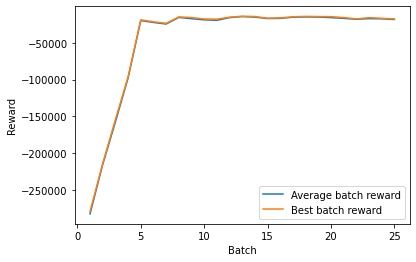

In [8]:
main()